# EinEverything or Dimensions Considered Harmful

In [302]:
!pip install dataclasses
!pip install einops
!pip install torch

In [0]:
import numpy

from PIL.Image import fromarray
from IPython import get_ipython


In [416]:
#!wget "https://github.com/arogozhnikov/einops/blob/master/docs/resources/test_images.npy?raw=true"
ims = numpy.load('test_images.npy?raw=true', allow_pickle=False)
# There are 6 images of shape 96x96 with 3 color channels packed into tensor
print(ims.shape, ims.dtype)

(6, 96, 96, 3) float64


# New Section

# Code

In [430]:
import re
group = re.match(r"\(([\w+ ?]+)\) -> (\w)+", "(A B) -> C")
print(group.groups())

('A B', 'C')


In [0]:
from einops import reduce, rearrange
from collections import OrderedDict

In [0]:
def test():
    EinTenor(np)

In [0]:
class EinDim:    
    def __init__(self, names, sizes, total_size):
        self.total_size = total_size
        nones = []
        used = 0
        for i, s in enumerate(sizes):
            if s is None:
                nones.append(i)
            else:
                used += s

        assert len(nones) <= 1, nones
        if nones:
            sizes[nones[0]] = total_size - used
        
        
        self.names = names
        self.sizes = sizes
        
    def to_einops(self):
        if len(self.names) == 1:
            return self.names[0]
        return "(" + " ".join(self.names) + ")"
       
    def size(self):
        return self.sizes
       
    def __repr__(self):
        return self.to_einops()
    
    def collapse(self, size):
        if len(self.names) == 1:
            return EinDim(self.names, self.sizes, self.total_size)
        else:
            return EinDim(["".join(self.names)], [None], self.total_size) 
    
        
class EinTensor:
    def __init__(self, tensor, dims):
        if isinstance(dims, str):
            dims = dims.split()
        self.tensor = tensor
        self.dims = dims 
        shape = self.tensor.shape
        self.sizes = OrderedDict(((d, shape[i]) for i, d in enumerate(self.dims)))
        self.axes = OrderedDict(((d, i) for i, d in enumerate(self.dims)))
    
    def _to_einops(self):
        return " ".join(self.dims)
    
    def shape(self):
        return self.sizes
    
    @staticmethod
    def parse_dims(tensor, dimstr, size_dict):
        t = dimstr.split()
        dims = []
        i = 0
        shape = tensor.shape

        while i < len(t):
            if not t[i].startswith("("):
                dims.append(EinDim([t[i]], [None], shape[len(dims)]))
                i += 1
            else:
                subdims = []
                sizes = []
                while True:
                    subdims.append(t[i].strip(")("))
                    sizes.append(size_dict.get(subdims[-1], None))
                    i += 1    
                    if t[i-1].endswith(")"): 
                        break   
                dims.append(EinDim(subdims, sizes, shape[len(dims)]))
        return dims
    
    
    def shift(self, *ops, **kwargs):
        tensor = self
        for op in ops:
            if op.strip().startswith("("):
                tensor = tensor._merge(op)
            elif op.strip().endswith(")"):
                tensor = tensor._split(op, **kwargs)
            else:
                tensor = tensor._rearrange(op)
        return tensor
      
    def _merge(self, mergestr):  
        group = re.match(r"\(([\w+ ?]+)\) -> (\w+)", mergestr)
        shape = self.tensor.shape
        strnames, dim = group.groups()      
        names = strnames.split()         
        s = ""
        ex = ""
        first = True
        for d in self.dims:    
            if d not in names:
                s += " " + d  
                ex += " " + d
            elif first:
                s += " (" + strnames + ")"
                ex += " " + dim
                first = False
       
        tensor = rearrange(self.tensor, "%s -> %s"%(self._to_einops(), s))
        print(ex)
        return EinTensor(tensor, ex)
        
    def _split(self, splitstr, **kwargs): 
        group = re.match(r"(\w+) -> \(([\w+ ?]+)\)", splitstr)
        dim, strnames = group.groups()
        names = strnames.split() 
        query = ""
        ex = ""
        for i, d in enumerate(self.dims):
            if d != dim:
                query += " " + d 
                ex += " " + d
            else:
                query += " (" + strnames + ")"
                ex += " " + strnames
                
        tensor = rearrange(self.tensor, "%s -> %s"%(query, ex),
                           **{d:kwargs[d] for d in names 
                              if d in kwargs})
        return EinTensor(tensor, ex)
        
    def _rearrange(self, term):
        assert ")" not in term
        recipe = "%s -> %s"%(self._to_einops(), term)
        tensor = rearrange(self.tensor, recipe)
        return EinTensor(tensor, term)
               
    def promote(self, dims):
        "Move dims to the front of the line" 
        term = [d for d in self.dims if d not in dims] + dims
        return self._rearrange(term) 
    
    
    def reduce(self, terms, op, **kwargs):
        ls = terms.split()
        term = " ".join([d for d in self.dims
                         if d not in ls])
        tensor = reduce(self.tensor,
                        "%s -> %s"%(self._to_einops(), term), op)
        return EinTensor(tensor, term)
    
 
    def apply(self, dim, axis_op):
        return axis_op(self.tensor, dim=self._to_axis(dim))
    
    @staticmethod
    def check(*tensors):
        sizes = {}
        failure = False
        for t in tensors:
            for k, v in t.sizes.items():
                if v == 1: continue
                if k in sizes:
                    failure = (failure or sizes[k] != v)
                else:
                    sizes[k] = v
        assert not failure, " ".join([str(t.sizes) for t in tensors])
    
    def _broadcast_to(self, other):
        s = ""
        ex = ""
        for d in other.dims:
            ex += " " + d
            if d in self.sizes:
                s += " " + d
            else:
                s += " ()"
        for d in self.dims:
            if d not in other.sizes:
                s += " " + d
                ex += " " + d   
        tensor = rearrange(self.tensor, "%s -> %s"% (self._to_einops(), s))
        return EinTensor(tensor, ex)
    
    @staticmethod
    def binop(op, a, b):
        a1 = a._broadcast_to(b)
        b1 = b._broadcast_to(a1)
        EinTensor.check(a1, b1)
        c = op(a1.tensor, b1.tensor)
        return EinTensor(c, a1.dims)

    def tensordot(self, other, keep=""):
        pass
    
    @staticmethod
    def lift(fn, in_spec, out_spec):
        in_spec = in_spec.split()
        out_spec = out_spec.split()
        def lifted(inp):
            inp = inp.promote(in_spec)
            batch_dims = [d for d in inp.dims not in in_spec]
            out = fn(inp.tensor)
            EinTensor(out, batch_dims + out_spec)
        return lifted
    
    def __repr__(self):
        return self.tensor
    
    
def numpy_to_png(a):
    assert 2 <= len(a.shape) <= 3, "Can't display {}-dimensional array of shape {}"\
        .format(len(a.shape), a.shape)
    return fromarray(numpy.array(numpy.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()

get_ipython().display_formatter.formatters['image/png'].for_type(EinTensor, lambda t: numpy_to_png(t.tensor))
get_ipython().display_formatter.formatters['text/plain'].for_type(EinTensor, lambda *x: "");

# Examples

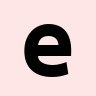

In [507]:
ims[0]
tensor = EinTensor(ims[0], "h w c")
tensor

In [508]:
tensor.shape()

OrderedDict([('h', 96), ('w', 96), ('c', 3)])

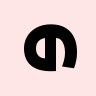

In [509]:
tensor.shift("w h c")

In [510]:
tensor = EinTensor(ims[0], "h w c")
tensor.shift('h -> (height q)', height=8).shape()

OrderedDict([('height', 8), ('q', 12), ('w', 96), ('c', 3)])

In [511]:
tensor = EinTensor(ims, 'b h w c')
tensor.shift('(b h) -> bh').shape()


 bh w c


OrderedDict([('bh', 576), ('w', 96), ('c', 3)])

 bw h c


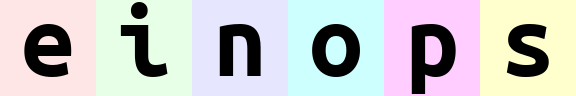

In [516]:
tensor.shift('(b w) -> bw', 'h bw c')


In [522]:
tensor.shift('(h b w c) -> full').shape()

 full


OrderedDict([('full', 165888)])

In [524]:
EinTensor(ims, "b h w c").shift('b -> (b1 b2)', 'b1 b2 h w c', b1=2).shape()

OrderedDict([('b1', 2), ('b2', 3), ('h', 96), ('w', 96), ('c', 3)])

 b1 a w c
 d a c


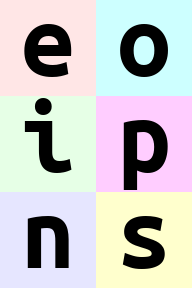

In [528]:
tensor.shift("b -> (b1 b2)", '(b2 h) -> a', '(b1 w) -> d', 'a d c', b1=2)

 b a w c
 d a c


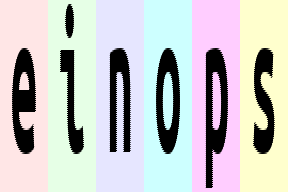

In [530]:
tensor.shift('w -> (w w2)', '(h w2) -> a', '(b w) -> d', 'a d c', w2=2)

 a h c


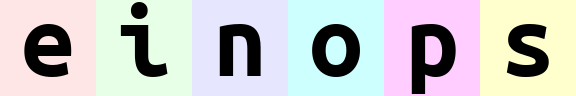

In [532]:
tensor.shift('(b w) -> a', 'h a c')

 a h c


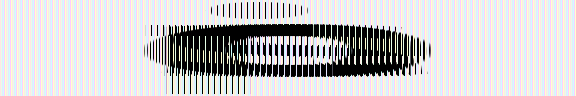

In [536]:
tensor.shift('(w b) -> a', 'h a c')

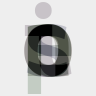

In [537]:
tensor = EinTensor(ims, 'b h w c')
tensor.reduce('b', 'mean')

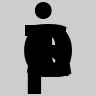

In [538]:
tensor.reduce('b c', 'min')


 h a c


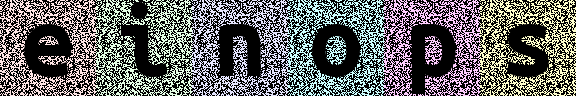

In [582]:
tensor = EinTensor(ims, 'b h w c')
mask = EinTensor(numpy.random.randint(0, 2, size=[96, 96]), 'h w')
EinTensor.binop(numpy.multiply, tensor, mask).shift('(b w) -> a', 'h a c')

In [0]:
tensor.merge(numpy.multiply, mask)

 bw h c


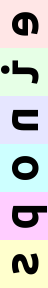

In [544]:
#reduce(ims, 'b (h h2) (w w2) c -> h (b w) c', 'mean', h2=2, w2=2)
tensor = EinTensor(ims, 'b h w c')
tensor.shift("h -> (h h2)", "w -> (w w2)", h2=2, w2=2).reduce("h2 w2", "mean").shift("(b w) -> bw")

 bw b2 h
 bw bh


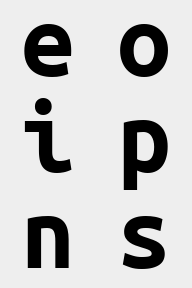

In [545]:
tensor = EinTensor(ims, 'b h w c')
tensor.shift("b -> (b1 b2)", b1 = 2).reduce('c', "mean").shift("(b1 w) -> bw", "(b2 h) -> bh", 'bh bw')


 h b2 w c
 h w c


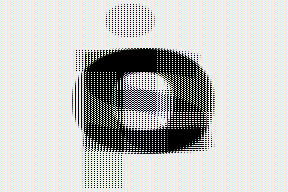

In [546]:
tensor.shift('b -> (b1 b2)', '(h b1) -> h', '(w b2) -> w', b1=2)